In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, warnings
from pathlib import Path
from natsort import natsorted
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from Bio import SeqIO

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, bootstrap_hl, bootstrap_hl_fast, hl2_bsl_fit, obj_hl2_bsl_fit, hl_ccF_bsl_fit, obj_hl_ccF_bsl_fit
from src.misc import moving_average, moving_std, find_nearest

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting_pub'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_half-life
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Determining aminoacylation half-life using tRNA-charge sequencing
In this notebook, I will process and analyze the samples generated to determine the aminoacylation half-life of a complex miture of human tRNAs isolated from tissue culture cells.
The summary of the finding of this analysis is:
* Data integrity is good, replicates are similar and no difference between independent sequencing runs
* The aminoacylation half-life was determined for >150 tRNA transcripts spanning all codons, all 20 amino acids and the cytoplasmic and mitochondrial comparments
* The tRNA-charge sequencing method is accurate to a level such that half-life is determined with small confidence intervals over 11 timepoint and 4 replicates
* Mitochondrial methionine and cytoplasmic selenocysteine data suggested a two-species half-life function
* Half-lifes measured in this work are directionally similar to past measurements
* The half-life magnitude is mostly determined by the identity of the amino acid attachment but a small effect is shown to be related to the tRNA discriminator base



### Sample description
To generate samples with a complex mixture of many aminoacylated tRNA transcripts, RNA was isolated from a human cell culture and used without further purification.
The RNA was kept buffered at pH=4.5 on ice before it was spiked with a physiological buffer and incubated at 20C whereafter samples were taken at 11 timepoints.
Sampling was performed by quenching with cold sodium acetate pH=4.5 and stored at -80C until further processing.
After the last timepoint, sample were processed following the standard tRNA-charge sequencing protocol with the exception of 4 non-oxidized samples controlling for RNA stability.



#### Protocol for preparing the timepoint samples
1. Isolate whole cell RNA from adherent cells using Trizol. Place dish on ice, thoroughly aspirate media, then add enough Trizol to cover the cells. From this point onwards, keep the RNA cold and work fast to retain tRNA acylation. Scrape cells and move to tube, add chloroform, vortex 1 min and spin. Precipitate RNA with IPA, spin and wash the pellet twice in acetate buffered 80% IPA (pH=4.5), then do a final wash in 100% IPA and dry RNA pellet. Dried RNA pellets can be stored at -80C for months without detectable loss of acetylation.
2. Prepare 5x physiological buffer solution using the following recipe:
 * 95 mM NaCl, 625 mM KCl, 1.65 mM CaCl2, 7 mM MgCl2, 2.5 mM Spermidine, 150 mM HEPES
 * Adjust pH to 7.2 with KOH
 * This is 5x concentration, final concentration will be 19 mM NaCl, 125 mM KCl etc.
 * Check for RNase acitivty with IDT RNalert kit
3. Prepare 4x11 1.5 mL tubes for timepoints by adding the following to the bottom of the tubes:
 * 2 uL 500 mM sodium acetate (pH=4.5)
 * 1 μL 5 ng/μL synthetic E.coli tRNA-Lys-UUU CCA
4. Prepare 4x4 1.5 mL tubes for t=0 timepoints by adding the following to the bottom of the tubes:
 * 1.6 uL 5x physiological buffer solution
 * 2 uL 500 mM sodium acetate (pH=4.5)
 * 1 μL 5 ng/μL synthetic E.coli tRNA-Lys-UUU CCA
5. Label each series of tubes 1 through 4 and the timepoints they are to contain.
6. Take dried RNA from -80C and reconstitute with 200 uL 1 mM sodium acetate and adjust to 1.5 ug/uL, move 80 uL to a 2x PCR tubes and keep on ice.
 * Start two time series exactly 11 minutes apart.
7. Just prior to starting, take a 6.4 uL sample and move it to the t=0 tube on ice.
8. Start the timeseries by adding 20 uL 5x physiological buffer solution (kept at room temperature), then mix by pipetting 10x 70 uL and move to 20C heat block on the PCR machine and start the timer.
 * Estimated time from adding, mixing, placed on incubator ~20 s.
9. Take 8 uL samples at each timepoint. Move to the prepared tubes with sodium acetate and mix when transferring.
 * Take sample at the following timepoints: 0, 4m, 8m, 16m, 32m, 1h, 2h, 4h, 8h, 16h, 40h, 40h (no oxidation control).
 * Save the remaining RNA and use it to check RNA integrity compared to starting material.
10. Store samples at -80C until further processing and repeat step 6 through 9 again to get a total of 4 repicates. 
11. Thaw tubes at 4C. Spin down in cold centrifuge and keep on ice. Now process one time-series at the time:
 * Follow the standard tRNA-charge sequencing protocol with a few modifications (shown on bold) to the oxidation steps due to KCl causing reduced solubility of NaIO4.
 * Process the non-oxidation control samples by swapping NaIO4 with NaCl.
 * Add 5 μL 200 mM NaIO4, mix and incubate __30 min__ on ice. 
 * Quench by adding 5 μL 50 % (v/v) ethylene glycol, mix and incubate __30 min__ on ice followed by __30 min at room temperature__.
 * Continue normal sample processing


### Read and filter input data
A sample list is provided to filter the samples for further use and add relevant sample level information.
The data is read from a .csv file with aggregated sample statistics.
This .csv file was generated using the standard process described in the tRNA-seq-charge repo and is the result of using the `STATS_collection` class.
Below the `TRNA_plot` class is used to extract the relevant tRNA charge information at transcript level.

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the half-life samples:
mask = (sample_df['plot_group'] == 'Acylation-half-life')
sample_df = sample_df[mask].reset_index(drop=True).copy()
sample_df['run_v1'] = np.array([fn[0:10] == '2022-12-28' for fn in sample_df['fastq_mate1_filename']])

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()

Folder exists and overwrite set to false... Doing nothing.


In [4]:
# Add E.coli control RPM to sample level information:
ectr = plot_obj.charge_filt['tr'][plot_obj.charge_filt['tr']['Ecoli_ctr']].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Extract dataframe with charge and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr', 'run_v1']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')

# Convert time to minutes:
time_list = list()
ox_list = list()
for sn in charge_df['sample_name']:
    if 'NoOx' in sn:
        time_list.append(40*60)
        ox_list.append(False)
    elif 'm' in sn:
        time_list.append(int(sn[:-1]))
        ox_list.append(True)
    elif 'h' in sn:
        time_list.append(int(sn[:-1])*60)
        ox_list.append(True)
    else:
        raise Exception('???')
charge_df['Time'] = time_list
charge_df['Ox'] = ox_list
charge_df['tRNA_anno_short'] = ['mito-'+an if mc else an for an, mc in zip(charge_df['tRNA_anno_short'], charge_df['mito_codon'])]
charge_df['xticklab'] = [str(t) if ox else str(t)+' NoOx' for t, ox in zip(charge_df['Time'], charge_df['Ox'])]

In [5]:
# Enforce minimum read count:
min_count = 1000
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                               charge_df['tRNA_annotation'], \
                               charge_df['Ecoli_ctr'], \
                               charge_df['count']):
    if ectr or cnt <= min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(charge_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = charge_df['tRNA_annotation'].isin(tann_sele)
filt_df = charge_df[mask].copy()
filt_df['RPM_norm'] = filt_df['RPM'] / filt_df['RPM_Ectr']

# Create dataframe for each tRNA annotation.
# To this the aminoacylatio half-life will be added later.
hl_df = filt_df.groupby(['tRNA_annotation', 'tRNA_anno_short', \
                         'tRNA_annotation_len', 'codon', 'anticodon', \
                         'AA_codon', 'amino_acid', 'AA_letter', 'mito_codon', \
                         'Ecoli_ctr']).agg(RPMnorm=('RPM_norm', 'mean'), \
                                           RPMmean=('RPM', 'mean'), \
                                           RPMstd=('RPM', 'std'), \
                                           RPMcv=('RPM', lambda x: x.std()/x.mean()*100)).reset_index()


### Check data integrity
Ploting the "charge" of the E.coli control tRNA in each sample.

The E.coli control was added to check that the NaIO4 oxidation and lysine cleavage reaction goes to completion and therefore should be 0% charged (i.e. all CC, no CCA); however, typically, a smaller percentage is sequenced as CCA and thus will appear as charged.
This is also apparent below, where most samples have a measured charge for the E.coli control samples of ~1% and only two samples are above 2%.
Whether this small residual "charge" reflects the incompletion of the NaIO4 oxidation and lysine cleavage reaction, an oligo defect or is a sequencing artifact is unknown, but we take it that the levels are so low that for most pratical purposes, including this analysis, the reaction can be assumed complete.

Also notice that the non-oxidized control samples are close to 100% charge.
Again, these are a few percentage point away from the expected value of 100% but this could easily be due to a small fraction of truncated oligos.
Below this, the measured charge for the real tRNAs in the non-oxidized control samples is plotted, showing almost 100% charge for all transcript and sample replicates.
This, along with RNA gels, is evidence that tRNAs are intact after the 40h incubation.

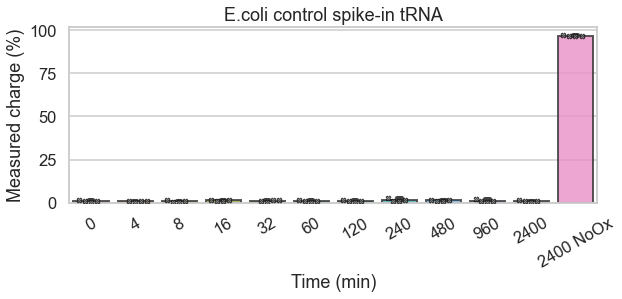

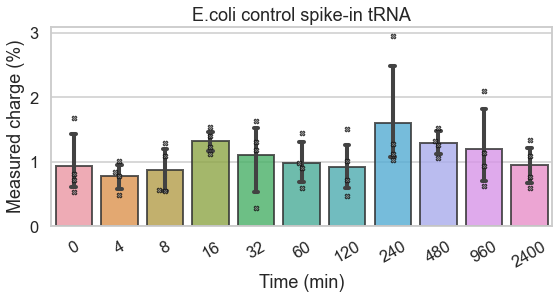

In [6]:
# Select E.coli controls samples:
ectr_mask = charge_df['Ecoli_ctr']
plot_df = charge_df[ectr_mask].copy()
# Indicator for the non-oxidized sample:
x_order = natsorted(set(plot_df['xticklab']))

# Plot:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 4.5))
    g1 = sns.barplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order)
    g1 = sns.swarmplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", order=x_order)
    g1.set(xlabel='Time (min)', ylabel='Measured charge (%)')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
    g1.set_title('E.coli control spike-in tRNA')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/ecoli-control_charge.pdf', bbox_inches='tight')


# Plot without the non-oxidized sample:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(8.3, 4.5))

    g1 = sns.barplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     order=x_order[:-1])
    g1 = sns.swarmplot(ax=ax1, data=plot_df, x='xticklab', y='charge', \
                       color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                       size=5, marker="X", order=x_order[:-1])
    g1.set(xlabel='Time (min)', ylabel='Measured charge (%)')
    g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
    g1.set_title('E.coli control spike-in tRNA')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/ecoli-control_charge_only-Ox.pdf', bbox_inches='tight')

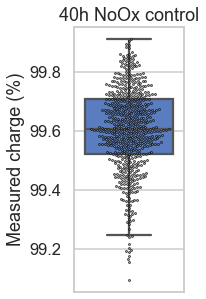

In [7]:
# Plot the charge for the
# non-oxidized control samples:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(3, 4.5))
    noxm = (charge_df['xticklab'] == '2400 NoOx') & (~charge_df['Ecoli_ctr']) & (charge_df['RPM'] > 1000)
    g1 = sns.boxplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, fliersize=False)
    g1 = sns.swarmplot(ax=ax1, y=charge_df.loc[noxm, 'charge'].values, \
                       color='grey', alpha=0.7, edgecolor='black', \
                       linewidth=0.8, size=2)
    g1.set(ylabel='Measured charge (%)')
    g1.set_title('40h NoOx control')
    fig.tight_layout()
    fig.savefig('data/plotting_pub/NoOx-control_charge.pdf', bbox_inches='tight')

In previous samples (charge titration) we have shown that the relative tRNA expression values measured in reads per million (RPM) is sensitive to sample processing steps such as adding an extra deacylation step.
However, samples undergoing identical processing should have comparable RPM values, and since all samples used in this notebook were made with the same RNA starting material but processed individually in an indentical way, they should fall under this category and have similar RPM values.

The RNA integrity was checked and validated by gel electrophoresis by the end of the experiment, but the RPM values could also be a validation that no significant RNA breakdown took place during the incubation time.
Therefore, let us look at a repressentable set of transcripts and their RPM values to check that nothing is changing.
We will do this using the coefficient of variance (CV) for the RPM values for each transcript across all timepoint samples to sort the most and least RPM variable transcripts.
Then taking the 0th, 10th, 20th, etc, percentile from this list and plot the RPM values from each sample to see if the variation is specific to a single sample, correlated with the time of sampling or something else.

The conclusion from this plotting (see below) is that the variance of RPM values is generally low, not associated with any particular timepoint and that the oxidized and non-oxidized samples are equal.
Furthermore, the distribution of the RPM CV values show that the RPM variability is moderately low; for most transcripts less than 10%.

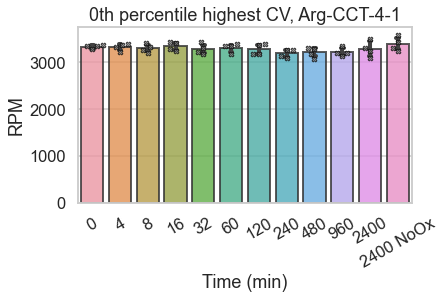

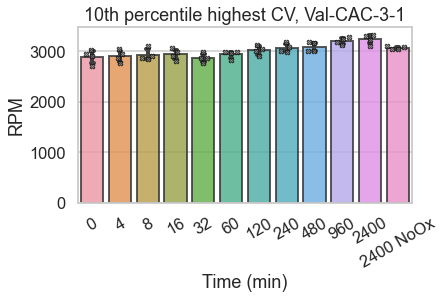

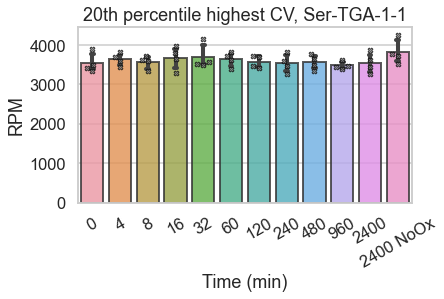

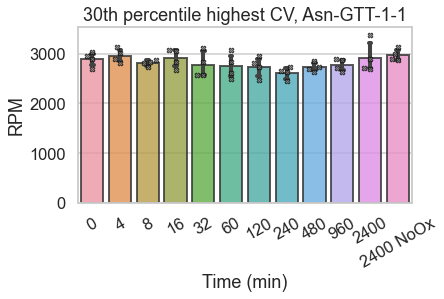

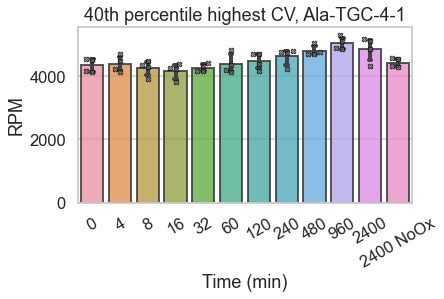

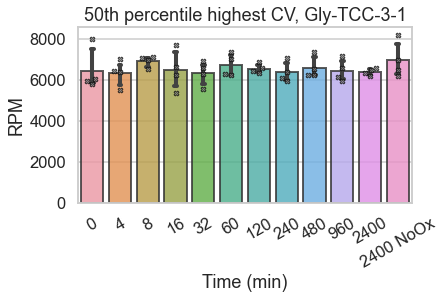

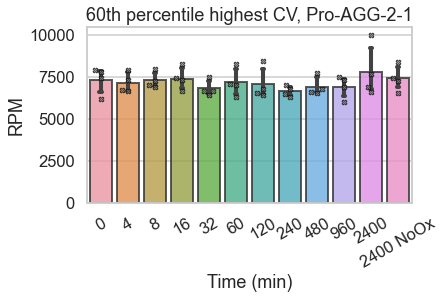

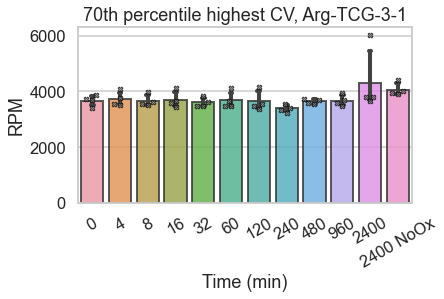

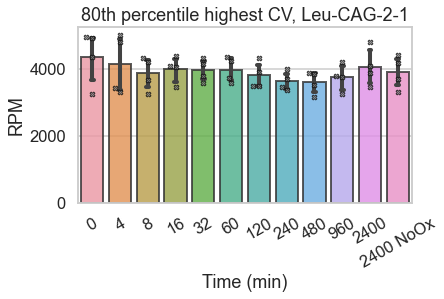

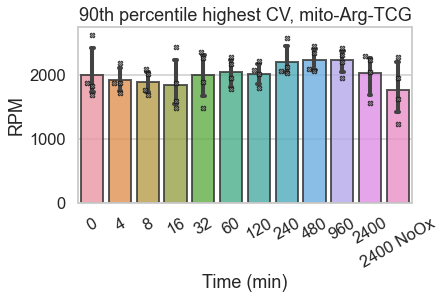

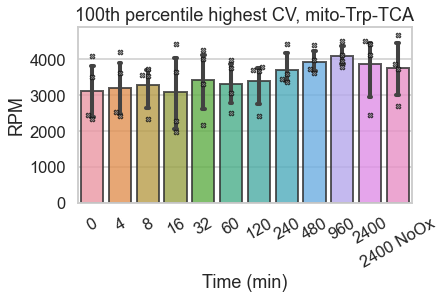

In [8]:
# Require minimum RPM value:
RPM_mask = hl_df['RPMmean'] > 2000
# Pick percentiles:
RPMcv_list = np.percentile(hl_df.loc[RPM_mask, 'RPMcv'], np.linspace(0, 100, 11), method='closest_observation')

# Plot:
prctl = 0
with PdfPages('data/plotting_pub/RPM_variance.pdf') as pp:
    for p_cv in RPMcv_list:
        anno = hl_df.loc[(hl_df['RPMcv'] == p_cv), 'tRNA_anno_short'].values[0]
        anno_mask = filt_df['tRNA_anno_short'] == anno
        bc_order = sorted(set(filt_df['barcode']))
        with sns.axes_style("whitegrid"):
            fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
            g1 = sns.barplot(ax=ax1, data=filt_df[anno_mask], x='xticklab', y='RPM', \
                             capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                             order=x_order)
            g1 = sns.swarmplot(ax=ax1, data=filt_df[anno_mask], x='xticklab', y='RPM', \
                               color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                               size=5, marker="X", order=x_order, warn_thresh=1)
            g1.set(xlabel='Time (min)', ylabel='RPM')
            g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
            g1.set_title('{}th percentile highest CV, {}'.format(prctl, anno))
            prctl += 10
            fig.tight_layout()
            pp.savefig(fig, bbox_inches='tight')

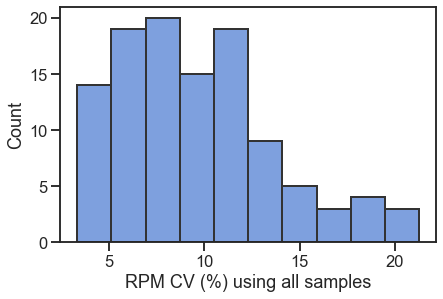

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
g1 = sns.histplot(data=hl_df[RPM_mask], x='RPMcv', bins=10, \
                  edgecolor=".2", linewidth=2, alpha=0.7,)
g1.set(xlabel='RPM CV (%) using all samples', ylabel='Count')

fig.tight_layout()
fig.savefig('data/plotting_pub/RPM_CV_histogram.pdf', bbox_inches='tight')

Lastly, we will look at the RPM repeatability in oxidized vs. non-oxidized samples.
This reinforces the above by showing good repeatability with moderate replicate variance.

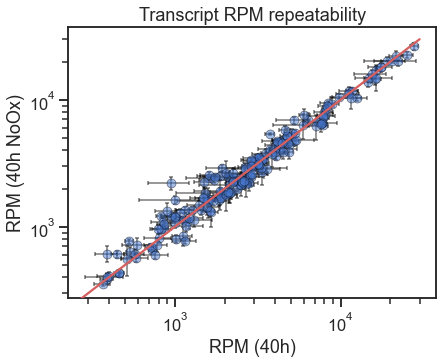

In [10]:
# Select oxidized and non-oxidized samples:
oxm = (filt_df['xticklab'] == '2400') & (~filt_df['Ecoli_ctr'])
noxm = (filt_df['xticklab'] == '2400 NoOx') & (~filt_df['Ecoli_ctr'])
rpm_cols = ['tRNA_anno_short', 'RPM']

# Aggregate to get the mean and standard deviation
# over the four replicates:
oxdf = filt_df.loc[oxm, rpm_cols].groupby('tRNA_anno_short').agg(RPMmean=('RPM', 'mean'), \
                                                                 RPMstd=('RPM', 'std')).reset_index()
noxdf = filt_df.loc[noxm, rpm_cols].groupby('tRNA_anno_short').agg(RPMmean=('RPM', 'mean'), \
                                                                   RPMstd=('RPM', 'std')).reset_index()
# Merge for plotting:
plot_df = oxdf.merge(noxdf, on='tRNA_anno_short', suffixes=('_40h', '_40h_NoOx'))

# Plot the RPM repeatability per transcript
# comparing oxidized vs. non-oxidized samples:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 5.4))
g1 = sns.scatterplot(ax=ax1, data=plot_df, x='RPMmean_40h', y='RPMmean_40h_NoOx', \
                     zorder=5, alpha=0.5, \
                     edgecolor='black', linewidth=0.7, legend=False)
g1.set_title('Transcript RPM repeatability')
g1.set(xlabel='RPM (40h)', ylabel='RPM (40h NoOx)')
g1.set_yscale('log', base=10)
g1.set_xscale('log', base=10)
ax1.errorbar(plot_df['RPMmean_40h'].values, plot_df['RPMmean_40h_NoOx'].values, xerr=plot_df['RPMstd_40h'].values, yerr=plot_df['RPMstd_40h_NoOx'].values, fmt='none', capsize=2, zorder=1, \
             ecolor='black', elinewidth=2, capthick=2, alpha=0.4)
ax1.plot([0, 30000], [0, 30000], c='r', zorder=10)
fig.tight_layout()
fig.savefig('data/plotting_pub/RPM_repeatability.pdf', bbox_inches='tight')

### Curve fitting to estimate the aminoacylation half-life

Aminoacylation decays over time in aqueous solution; presumably, due to nucleophilic attack of the acyl ester bond and likely by $\text{OH}^-$.
In other words: hydrolysis.
This will of course be pH dependent, but since the experiment is run in a high buffering capacity buffer, pH can be assumed constant and thus the reaction becomes a simple first-order reaction.
As we measure relative and not absolute concentrations of aminoacylated and non-aminoacylated species it is most appropriate, and intuitive, to describe the reaction rate using the half-life of the tRNA charge.

We thus have the following equation:
$$
N(t) = N_0 \left( \frac{1}{2} \right) ^\frac{t}{t_{1/2}} + N_{\infty}
$$
Where $N(t)$ is the charge as a function of time, $N_0$ is the charge at time zero and $t_{1/2}$ is the half-life.
The more unfamiliar $N_{\infty}$ is the lower asymptote of the charge.
In a perfect assay, $N_{\infty}$ would take the value of 0 and thus behave as a textbook first-order reaction; however, a minor fraction of tRNA will persist to appear as charged no matter what the actual level of aminoacylation is and we must allow the model to fit this.
A good example of the is the E.coli spike-in control samples shown above.
We will allow this parameter to take a value between 0 and 3.5%.

The above can be transformed into a linear function with the dependent variable on the left hand side and two independent variables on the right hand side.
$$
log_2(N(t) - N_{\infty}) = log_2(N_0) - t \frac{1}{t_{1/2}}
$$

It would be convenient to use the linear function because it is convex and it has a closed form solution that is fast to calculate; however, we would have to guess $N_{\infty}$ each time.
We could probably use gradient search to speed up finding $N_{\infty}$ but that defeats the purpose of using a closed form solution.
Instead, we will wrap the exponential decay function (the top equation) into an optimization routine 
and use BFGS to perform parameter optimization.
We end up fitting three parameters to 11 timepoints with each 4 replicates.

In [11]:
# Function to plot the time-series
# charge data along with the fitted half-life function:
def plot_hl(df, p_est, ci, plot_return=True, plot_fh=None):
    fig = plt.figure(figsize=(15, 9))
    gs = fig.add_gridspec(2, 6)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2:4])
    ax3 = fig.add_subplot(gs[0, 4:6])
    ax4 = fig.add_subplot(gs[1, 1:3])
    ax5 = fig.add_subplot(gs[1, 3:5])
    
    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y = hl_bsl_fit(fit_x, *p_est)
    fit_yb = hl_bsl_fit(fit_x, *ci[0])
    fit_yt = hl_bsl_fit(fit_x, *ci[1])

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax1.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax1.plot(fit_x, fit_y, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax2.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax2.plot(fit_x, fit_y, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=True)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    ax3.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax3.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax3.plot(fit_x, fit_y, c='r', zorder=3)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')

    # Plot prediction errors with moving mean
    # as a function of time:
    g4 = sns.scatterplot(ax=ax4, data=df, x='Time+1', y='pred_err', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g4.set_xscale('log', base=2)
    # Moving mean:
    chs = df.sort_values(by='Time+1', ascending=False)['Time+1'].values
    prs = df.sort_values(by='Time+1', ascending=False)['pred_err'].values
    ax4.plot(moving_average(chs, n=3), moving_average(prs, n=3), color='r')
    g4.set(xlabel='Time (min)', ylabel='Error (mes - pred; %)')
    g4.set_title('Prediction error')

    
    # Plot prediction errors with moving mean
    # as a function of measured charge:
    g5 = sns.scatterplot(ax=ax5, data=df, x='charge', y='pred_err', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    # Moving mean:
    chs = df.sort_values(by='charge', ascending=False)['charge'].values
    prs = df.sort_values(by='charge', ascending=False)['pred_err'].values
    ax5.plot(moving_average(chs, n=3), moving_average(prs, n=3), color='r')
    g5.set(xlabel='Charge (%)', ylabel='Error (mes - pred; %)')
    g5.set_title('Prediction error')


    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{} half-life={:.0f} min, 95% CI ({:.0f}; {:.0f})'.format(tRNA_name, p_est[1], ci[0][1], ci[1][1]), size=16);
    fig.tight_layout()
    
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting_pub/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)


In [12]:
# Run analysis on half-life data
# one tRNA transcript at the time:
res = list()
pred_list = list()
index_list = list()
with PdfPages('data/plotting_pub/hl-fit.pdf') as pp:
    for tann in hl_df['tRNA_annotation']:
        # Extract dataframe with single tRNA annotation:
        sample_mask = (filt_df['tRNA_annotation'] == tann) & (filt_df['Ox'])
        hl_spl = filt_df[sample_mask].copy()
        # Infer half-life point estimate and 
        # bootstrap the confidence interval:
        residual, p_est, ci = bootstrap_hl(hl_spl, Ndraws=100, BFGS_loss_func=loss_func_l2, lstsq=False)
        pred = hl_bsl_fit(hl_spl['Time'].values, *p_est)
        pred_list.extend(pred)
        index_list.extend(hl_spl.index.values)

        # Plot the fit:
        aa = hl_spl['tRNA_anno_short'].values[0].split('-')[0]
        hl_spl['pred_err'] = hl_spl['charge'] - pred
        plot_hl(hl_spl, p_est, ci, plot_fh=pp, plot_return=False)
        # Store results:
        res.append([residual, p_est[1], \
                    ci[0][1], ci[1][1], (p_est, ci)])

# Add results to dataframe:
hl_df['hl_residual'] = [row[0] for row in res] # these are taken on the mean replicate charge
hl_df['hl_p_est'] = [row[1] for row in res]
hl_df['res_ci_l'] = [row[2] for row in res]
hl_df['res_ci_u'] = [row[3] for row in res]
hl_df['res_param'] = [row[4] for row in res]

# Add results to sample level information:
filt_df['charge_pred'] = np.nan
filt_df.loc[index_list, 'charge_pred'] = pred_list
filt_df['pred_err'] = filt_df['charge'] - filt_df['charge_pred']

We can check the results by looking at the fit for a random trancript.
The left scatterplot shows the measured charge as a function of time.
It shows an exponential decay of charge with the fitted decay function as a red line and the 95% confidence interval of this in dashed green lines.
The middle plot has been log transformed on the y-axis to show the linear relationship that results.
Because a minimum charge parameter is included in the decay function, it bends off to a lower asymptote.
The right plot has been log transformed on the x-axis to evenly spread out the timepoints.
Also notice, in the right plot, that time 0 has been set to 1 to avoid $\text{log2}(0)$.

Generally, the replicates show similar charge, the points fall close to the fitted decay function and the confince interval is narrow.
This confirms that the tRNA charge sequencing method can be used to measure the aminoacylation half-life of individual tRNA transcripts pooled together.

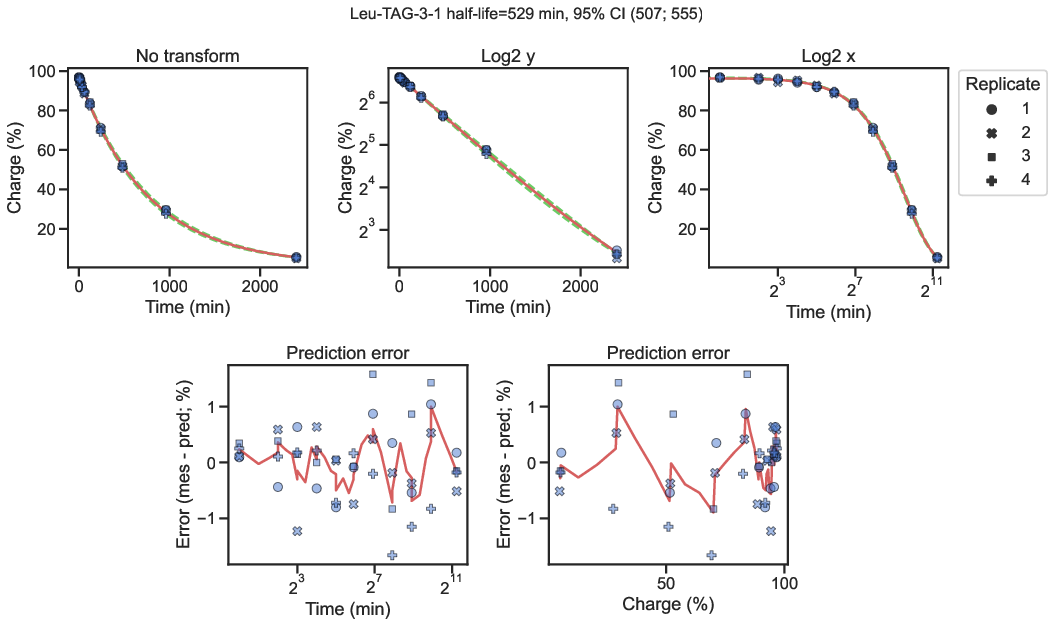

In [13]:
random_image = np.random.randint(len(hl_df['tRNA_annotation']))
img = WImage(filename='data/plotting_pub/hl-fit.pdf[{}]'.format(random_image))
img

However, there are some transcripts were the decay function does not seem to fit the data so well.
One example is mitochondrial methionine tRNA which is used in mitochondrial translation both as an initiator and in normal elongation.
As an initator the methionine is formylated while attached to the tRNA (fMet), thus two different aminoacylation species exist.
This could explain the deviation from the, implicitly assumed, single species decay function.

First, let us look more formally at the largest sum of squared residuals for the annotations:

In [14]:
hl_df.sort_values(by='hl_residual', ascending=False).reset_index().loc[0:30, ['tRNA_anno_short', 'hl_residual']].head(20)

,tRNA_anno_short,hl_residual
0,mito-Met-CAT,128.162876
1,SeC-TCA-1-1,59.756974
2,Gln-TTG-1-1,30.169005
3,Gln-TTG-2-1,29.211206
4,Cys-GCA-9-1,14.060201
5,Cys-GCA-4-1,13.762005
6,Gln-TTG-3-1,13.294279
7,Gln-CTG-4-1,13.180241
8,Gln-CTG-2-1,12.859420
9,Cys-GCA-6-1,12.487701


The residuals validate that mitochondrial methionine tRNA is not modeled well by the single species decay function, but also selenocysteine (SeC) is having high residuals.
Coincidentally, like mito-Met/fMet, SeC is also modified on the tRNA.
Initially, the SeC-tRNA is aminoacylated with serine, then this serine is phosphorylated and finally the phosphate is replaced by selenium to make selenocysteine.
In this case three aminoacylation species could exist.

As we go down the list several Gln/Cys codons have high residuals, although small compared to mito-Met and SeC.
However, these look distinct from mito-Met and SeC and appear to have a large residual due to high replicate variance rather than bad decay function fit.

Nevertheless, it is trivial to model a two species decay function with species $A$ and $B$:
$$
N(t) = N^A_0 \left( \frac{1}{2} \right) ^\frac{t}{t^A_{1/2}} + N^B_0 \left( \frac{1}{2} \right) ^\frac{t}{t^B_{1/2}} + N_{\infty}
$$

Here $N^A_0$ and $N^B_0$ are the initial percentage point charge of species $A$ and $B$ and each have an associated half-life $t^A_{1/2}$ and $t^B_{1/2}$, respectively.
Thus, the model goes from three parameters to five.

Below, we shall see how this two species model fit the data.

In [15]:
# Function to test the two-species model:
def test_two_species(inp_df, short_anno):
    sample_mask = (inp_df['tRNA_anno_short'] == short_anno) & (inp_df['Ox'])
    df = inp_df[sample_mask].copy()
    ch_dat = dict()
    for t, ch in zip(df['Time'], df['charge']):
        if t in ch_dat:
            ch_dat[t].append(ch)
        else:
            ch_dat[t] = list()
            ch_dat[t].append(ch)

    time_arr = np.array(list(ch_dat.keys()))
    mean = np.zeros(len(ch_dat))

    # Allow two species:
    bnds = ((0, 100), (0, 100), (1, 1e5), (1, 1e5), (0, 3.5))
    guess = (90, 10, 5000, 50, 1)
    for i, t in enumerate(time_arr):
        mean[i] = np.mean(ch_dat[t])
    def fun_hl2_bsl(p): return(obj_hl2_bsl_fit(loss_func_l2, mean, time_arr, p))
    p_hl_bsl = minimize(fun_hl2_bsl, guess, method='L-BFGS-B', bounds=bnds)
    
    return((p_hl_bsl.fun, p_hl_bsl.x))


In [16]:
# Function to plot the comparison between
# a one and a two species model:
def compare_one_two(df, p1, p2, plot_return=True):
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    # Half-life fit and confidence interval:
    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y1 = hl_bsl_fit(fit_x, *p1)
    fit_y2 = hl2_bsl_fit(fit_x, *p2)

    # No transformation:
    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', style='replicate', \
                         markers=True, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g1.set_title('No transform')
    g1.set(xlabel='Time (min)', ylabel='Charge (%)')
    ax1.plot(fit_x, fit_y1, c='g', zorder=2)
    ax1.plot(fit_x, fit_y2, c='r', zorder=3)

    # Log transformed y-axis:
    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7, legend=False)
    g2.set_title('Log2 y')
    g2.set(xlabel='Time (min)', ylabel='Charge (%)')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_y1, c='g', zorder=2)
    ax2.plot(fit_x, fit_y2, c='r', zorder=3)

    # # Log transformed x-axis:
    df['Time+1'] = df['Time'] + (df['Time'] == 0) * 1
    g3 = sns.scatterplot(ax=ax3, data=df, x='Time+1', y='charge', style='replicate', \
                         markers=True,  zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set(xlabel='Time (min)', ylabel='Charge (%)')
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    sns.move_legend(g3, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Replicate')
    ax3.plot(fit_x, fit_y1, c='g', zorder=2)
    ax3.plot(fit_x, fit_y2, c='r', zorder=3)

    tRNA_name = df['tRNA_anno_short'].values[0]
    fig.suptitle('{}, two-species at [{:.0f}, {:.0f}] percentage point initial charge, half-life=[{:.0f}, {:.0f}] min'.format(tRNA_name, *p2), size=16);
    fig.tight_layout()
    fig.savefig('data/plotting_pub/{}_two-species_model.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)

In [17]:
# Fit a two species model to each transcript
# and see how this affects the residuals:
two_fit = [test_two_species(filt_df, ta) for ta in hl_df['tRNA_anno_short']]
hl_df['two_fit_residual'] = [tf[0] for tf in two_fit]
hl_df['two_fit_params'] = [tf[1] for tf in two_fit]
hl_df['one-two_resi'] = hl_df['hl_residual'] / hl_df['two_fit_residual']
hl_df.sort_values(by='one-two_resi', ascending=False).loc[:, ['tRNA_anno_short', 'hl_residual', 'one-two_resi']].head(8)

,tRNA_anno_short,hl_residual,one-two_resi
13,mito-Met-CAT,128.162876,143.253906
132,SeC-TCA-1-1,59.756974,47.406880
97,Ile-TAT-2-1,1.134423,14.256536
165,Val-AAC-1-1,2.522522,9.749348
166,Val-AAC-2-1,1.486713,9.289038
96,Ile-TAT-1-1,2.124530,5.926773
168,Val-CAC-1-1,1.135814,5.233214
172,Val-TAC-1-1,0.193323,3.121049


In the list above the `one-two_resi` column is the residuals of the one species model devided by those from the two species model i.e. higher mean better fit.
Clearly, mito-Met and SeC have a massively improved fit which we will see plotted below.
Some isoleucine and valine tRNAs are also better; however, these transcripts already have low residuals with the one species model and thus this will remain their preferred model.

The plots below have similar layout as those plots used for single species decay function fit, without the confidence interval.
The green line is the one species model, the red line is the two species model.
From the figure title we can see that at time zero the mito-Met is inferred to be 53% aminoacylated with species A, 41% aminoacylated with species B and 6% unaminoacylated.
We can also read that species A is inferred to have a half-life of 3586 min, whereas species B has a half-life of 387 min.
Species B is likely methionine which has a similar half-life (~450 min) when attached to cytoplasmic tRNAs.
Species A would then be formyl-methionine, so why is fMet aminoacylation so much more stable?
Probably, because the N-formyl group shifts electrons towards to aminoacyl ester bond making it less
susceptible to nucleophilic attack.
This has previously been observed (see Schofield & Zamecnik 1968) for both N-formyl and N-acetyl aminoacylated tRNAs.

For SeC, the major species A has an inferred half-life of 417 min, which is right between the ~600 and ~200 min of Ser and Cys, respectively.
The minor species B has a short half-life of only 17 min.
If true, this would be the shortest amino acylation half-life measured in this experiment.
It seems most likely that the major species is the actual product: selenocysteine, and since species B has such short half-life it is most likely the intermediate phosphoserine.

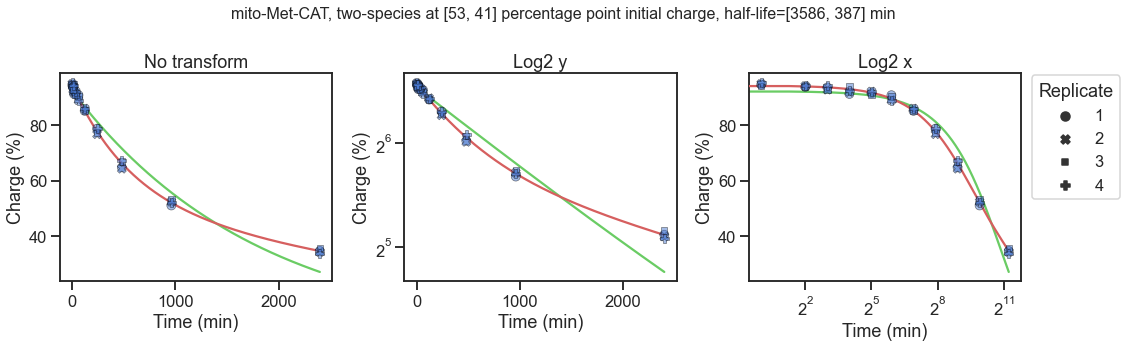

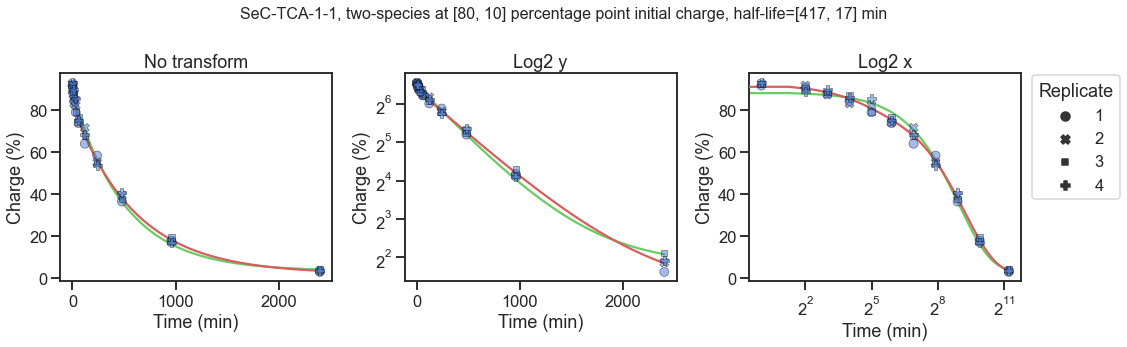

In [18]:
# Plot the comparison betwen one and two species models:
for anno in ['mito-Met-CAT', 'SeC-TCA-1-1']:
    sample_mask = (filt_df['tRNA_anno_short'] == anno) & (filt_df['Ox'])
    hl_spl = filt_df[sample_mask].copy()
    hl_anno_mask = hl_df['tRNA_anno_short'] == anno
    p1 = hl_df.loc[hl_anno_mask, 'res_param'].values[0][0]
    p2 = hl_df.loc[hl_anno_mask, 'two_fit_params'].values[0]
    compare_one_two(hl_spl, p1, p2)

In [19]:
# Write half-life results to .csv file:
hl_df['N0'] = [rp[0][0] for rp in hl_df['res_param']]
hl_df['hl'] = [rp[0][1] for rp in hl_df['res_param']]
hl_df['Ninf'] = [rp[0][2] for rp in hl_df['res_param']]

pcols = ['tRNA_annotation', 'tRNA_annotation_len', 'codon', 'amino_acid', 'mito_codon', \
         'hl', 'res_ci_l', 'res_ci_u', 'N0', 'Ninf', 'hl_residual']
prows = (hl_df['one-two_resi'] < 30)
one_species_tab = hl_df.loc[prows, pcols].rename(columns={'res_ci_l': 'hl_ci_l', 'res_ci_u': 'hl_ci_u'})
one_species_tab.to_csv('acylation_half-lifes.csv', index=False)


hl_df['NA0'] = [rp[0] for rp in hl_df['two_fit_params']]
hl_df['NB0'] = [rp[1] for rp in hl_df['two_fit_params']]
hl_df['hlA'] = [rp[2] for rp in hl_df['two_fit_params']]
hl_df['hlB'] = [rp[3] for rp in hl_df['two_fit_params']]
hl_df['Ninf'] = [rp[4] for rp in hl_df['two_fit_params']]

pcols = ['tRNA_annotation', 'tRNA_annotation_len', 'codon', 'amino_acid', 'mito_codon', \
         'NA0', 'NB0', 'hlA', 'hlB', 'Ninf', 'two_fit_residual']
prows = (hl_df['one-two_resi'] > 30)
two_species_tab = hl_df.loc[prows, pcols].copy()
two_species_tab.to_csv('acylation_half-lifes_two-species.csv', index=False)

### Addressing the possible failure modes of tRNA-charge sequencing

The five different failure modes were listed and discussed in the data processing noteook for the charge titration data (see the `charge_titration` folder under projects).
Here is a summary of the five points and data relevant for each:
1. Oxidation does not run to completion => charge overestimate
    * Tested with an E.coli spike-in for all samples and a set of fully deacylated samples. Data support the oxidation to be somewhere between 99-100% complete. Apparent incomplete oxidation can be explained by other factors such as biological errors in the CCA-end attachment.
2. Base cleavage/dephosphorylation does not run to completion => charge overestimate
    * Tested by various RNA gels on synthetic oligo tRNA and tRNAs isolated from cell lines. These gels support that ligation goes to completion and thus cleavage/dephosphorylation must also be complete.
3. Low RNA integrity => charge underestimate
    * Tested routinely by RNA gels and through non-oxidized control samples. Data support high RNA integrity with minimal to no effect on charge measurements. Non-oxidized control samples suggest an upper bound of 0.5% effect on charge measurements.
4. Adapter ligation bias => charge overestimate
    * Tested with RNA gel of ligation reaction and by charge titration data comparing measured vs. predicted charge broken down by barcoded adapters. RNA gels suggest that ligation goes to completion and sequencing data support no preference in acylated vs. deacylated substrate for ligation, with the exception of adapter l4Sp, which shows a slight preference for CCA ligation (i.e. higher charge measurements).
5. Deacylation is incomplete => charge underestimate
    * Tested using deacylated control samples. Data support that >99% of tRNAs are deacylated with the exception of fMet-tRNAs which had 5-7% charge remaining. This could be improved by doubling the deacylation incubation time to 8 hours; however, this comes at the cost of reduced RNA integrity which would influence the charge measurement in other ways.

Here, we shall look at the possible adapter ligation bias further below, but first we need to consider the possible effect of incomplete cleavage/dephosphorylation.
This effect can be considered as a fraction of the uncharged tRNAs that remains uncleavage/phosphorylation and thus unavailable for ligation i.e. these tRNAs drop out.
Below, a cleavage/dephosphorylation completeness fraction of 0.8 is used as an example of how this would affect charge half-life data of a tRNA with amnoacyl half-life of 100 min.

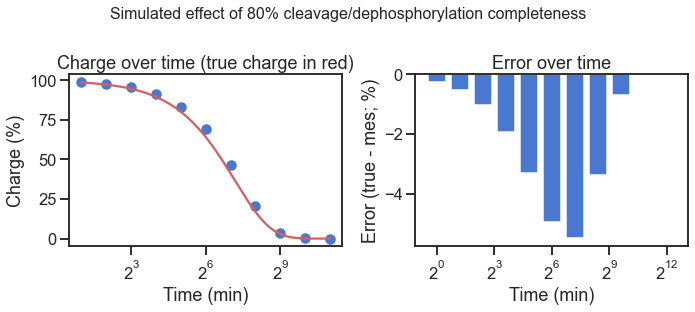

In [20]:
# Generate data:
ccF = 0.8 # fraction of complete cleavage/dephosphorylation
hl = 100  # half-life
hl_true = hl
N0 = 100  # charge at t=0
time_list = np.logspace(1, 11, 11, base=2)
true_charge = N0 * (1/2)**(time_list/hl)

# Find measured charge,
# given incomplete cleavage/dephosphorylation:
ch_list = list()
for t in time_list:
    cca = N0 * (1/2)**(t/hl)
    cc = N0 - cca
    cc *= ccF
    ch = cca/(cc+cca) * 100
    ch_list.append(ch)
ch_list = np.array(ch_list)

# Plot results:
fig = plt.figure(figsize=(10, 4.5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.scatter(time_list, ch_list)
x = np.logspace(1, 11, 1000, base=2)
y = N0 * (1/2)**(x/hl)
ax1.plot(x, y, color='r');
ax1.set_xscale('log', base=2)
ax1.set_title('Charge over time (true charge in red)')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Charge (%)')

true_charge = N0 * (1/2)**(time_list/hl)
ax2.bar(np.arange(len(ch_list)), (true_charge - ch_list))
ax2.set_title('Error over time')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Error (true - mes; %)')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax2.set_xticklabels(ax1.get_xticklabels());

fig.suptitle('Simulated effect of 80% cleavage/dephosphorylation completeness', size=16);
fig.tight_layout()

So with incomplete cleavage/dephosphorylation the charge is overestimated and the error is highest when the true charge is 50%.
However, for real data we do not know the underlying true half-life, instead we infer it based on the data.
We will perform a similar operation and observe the outcome.

Half-life true: 100.00
Half-life predicted: 115.61


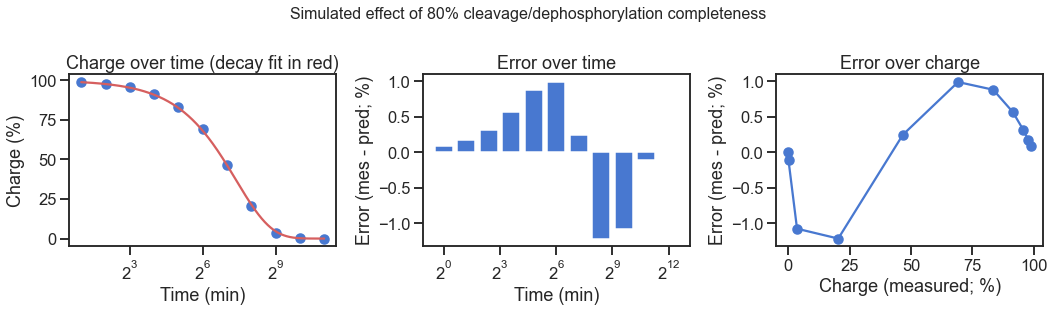

In [21]:
# Half-life function fit with baseline:
def hl_bsl_fit(t, N0, hl, Ninf):
    return(N0*(1/2)**(t/hl)+Ninf)
def obj_hl_bsl_fit(loss_func, mes, t, p):
    N0 = p[0]
    hl = p[1]
    Ninf = p[2]
    y = hl_bsl_fit(t, N0, hl, Ninf)
    loss = sum(loss_func(mes, y))
    return(loss)

# Set baseline to zero with bounds:
bnds = ((0, 100), (1, 1e5), (0, 0.001))
guess = (100, 500, 1)
def fun_hl_bsl(p): return(obj_hl_bsl_fit(loss_func_l2, ch_list, time_list, p))
p_hl_bsl = minimize(fun_hl_bsl, guess, method='L-BFGS-B', bounds=bnds)
N0 = p_hl_bsl.x[0]
hl = p_hl_bsl.x[1]
residual = p_hl_bsl.fun

# Plot results:
fig = plt.figure(figsize=(15, 4.5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

ax1.scatter(time_list, ch_list)
x = np.logspace(1, 11, 1000, base=2)
y = N0 * (1/2)**(x/hl)
ax1.plot(x, y, color='r');
ax1.set_xscale('log', base=2)
ax1.set_title('Charge over time (decay fit in red)')
ax1.set_xlabel('Time (min)')
ax1.set_ylabel('Charge (%)')

pred_charge = N0 * (1/2)**(time_list/hl)
ax2.bar(np.arange(len(ch_list)), (ch_list - pred_charge))
ax2.set_title('Error over time')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Error (mes - pred; %)')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax2.set_xticklabels(ax1.get_xticklabels());

ax3.scatter(ch_list, (ch_list - pred_charge))
ax3.plot(ch_list, (ch_list - pred_charge))
ax3.set_title('Error over charge')
ax3.set_xlabel('Charge (measured; %)')
ax3.set_ylabel('Error (mes - pred; %)')

fig.suptitle('Simulated effect of 80% cleavage/dephosphorylation completeness', size=16);
fig.tight_layout()
print('Half-life true: {:.2f}\nHalf-life predicted: {:.2f}'.format(hl_true, hl))

From the above we can conclude, that data with incomplete cleavage/dephosphorylation causes the fitted decay function to overestimate the half-life and, while the parameter fitting partially masks the error between true and measured charge, it still does not give a perfect fit to the data.
The difference between measurements and decay function predictions has a characteristic shape with prediction overestimates at low charge and prediction underestimates at high charge.
We can look for this characteristic shape in the real data to find evidence of incomplete cleavage/dephosphorylation.

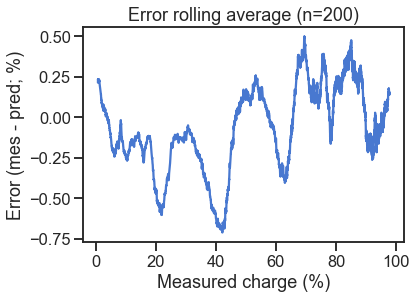

In [22]:
# Plot the prediction error as a function
# of charge to look for patterns:
roll_mask = (~filt_df['pred_err'].isna()) & (~filt_df['tRNA_anno_short'].isin(['SeC-TCA-1-1', 'mito-Met-CAT']))
chs = filt_df[roll_mask].sort_values(by='charge', ascending=False)['charge'].values
prs = filt_df[roll_mask].sort_values(by='charge', ascending=False)['pred_err'].values

fig = plt.figure(figsize=(6, 4.5))
gs = fig.add_gridspec(1, 1)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(moving_average(chs, n=200), moving_average(prs, n=200))
ax1.set_title('Error rolling average (n=200)')
ax1.set_ylabel('Error (mes - pred; %)')
ax1.set_xlabel('Measured charge (%)')
fig.tight_layout()
fig.savefig('data/plotting_pub/charge_prediction-error_rolling.pdf', bbox_inches='tight')

The above plot is showing the rolling average prediction error for all the samples with an inferred half-life.
In case of incomplete cleavage/dephosphorylation we would expect a characteristic shape more like the one observed above.
But this plot is also an aggregate of many error profiles from different transcripts with different half-lifes, so we should test whether the lack of the characteristic shape is due to this aggregation.
The best way to deal with that is to simulate the data using the same or similar parameters as in the real dataset but injecting an error that is controlled by the fraction of complete cleavage/dephosphorylation (this parameter is named ccF below).

In [23]:
# Find the standard deviation
# closest to the charge:
def ch_std(ch, ch_rol, err_rol):
    std = list()
    for chi in ch:
        idx = find_nearest(ch_rol, chi)
        std.append(err_rol[idx])
    return(np.array(std))

# Half-life function fit with baseline:
def hl_bsl_fit(t, N0, hl, Ninf):
    return(N0*(1/2)**(t/hl)+Ninf)
def obj_hl_bsl_fit(loss_func, mes, t, p):
    N0 = p[0]
    hl = p[1]
    Ninf = p[2]
    y = hl_bsl_fit(t, N0, hl, Ninf)
    loss = sum(loss_func(mes, y))
    return(loss)

# Simulate the error profile described above
# using the half-lifes inferred:
def simulate_err_profile(hl_df, ccF, ch_rol, err_rol, noise_scale=1, roll_avg=200):
    # Extract half-life data:
    N0_list = [p[0][0] for p in hl_df.loc[:, 'res_param'].values]
    hl_list = [p[0][1] for p in hl_df.loc[:, 'res_param'].values]
    st = np.array(sorted(set(charge_df['Time'])))

    err = list()
    ch_all = list()
    for N0, hl in zip(N0_list, hl_list):
        # Find measured charge,
        # given incomplete cleavage/dephosphorylation:
        ch_list = list()
        for t in time_list:
            cca = N0 * (1/2)**(t/hl)
            cc = N0 - cca
            cc *= ccF
            ch = cca/(cc+cca) * 100
            ch_list.append(ch)
        ch_list = np.array(ch_list)
        # Add random noise from distribution
        # similar to that of real data:
        std_list = ch_std(ch_list, ch_rol, err_rol)
        mes_noise = np.random.normal(loc=0, scale=std_list*noise_scale, size=len(ch_list))
        ch_list += mes_noise
        ch_list[ch_list < 0] = 0
        ch_list[ch_list > 100] = 100

        # Set baseline to zero with bounds:
        bnds = ((0, 100), (1, 1e5), (0, 0.001))
        guess = (100, 500, 1)
        def fun_hl_bsl(p): return(obj_hl_bsl_fit(loss_func_l2, ch_list, time_list, p))
        p_hl_bsl = minimize(fun_hl_bsl, guess, method='L-BFGS-B', bounds=bnds)
        N0 = p_hl_bsl.x[0]
        hl = p_hl_bsl.x[1]
        pred_charge = N0 * (1/2)**(time_list/hl)

        # Find the prediction errors:
        err.extend(list(ch_list - pred_charge))
        ch_all.extend(list(ch_list))

    # Plot prediction error vs measured charge:
    df = pd.DataFrame([ch_all, err]).T.rename(columns={0:'measured_charge', 1: 'pred_err'}).sort_values(by='measured_charge').reset_index(drop=True)

    fig = plt.figure(figsize=(6, 4.5))
    gs = fig.add_gridspec(1, 1)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(moving_average(df['measured_charge'].values, n=roll_avg), moving_average(df['pred_err'].values, n=roll_avg))
    ax1.set_title('Prediction error profile, ccF={}'.format(ccF))
    ax1.set_ylabel('Error (mes - pred; %)')
    ax1.set_xlabel('Measured charge (%)')
    fig.tight_layout()

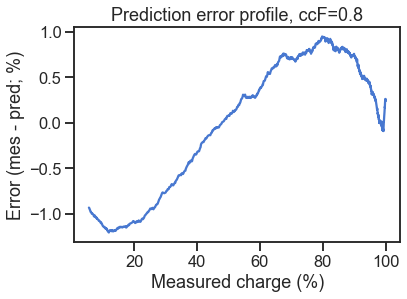

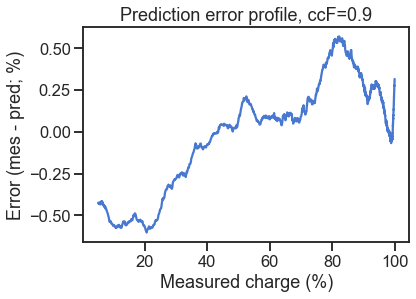

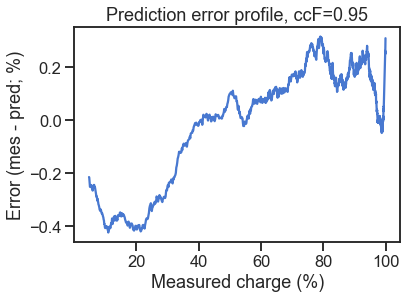

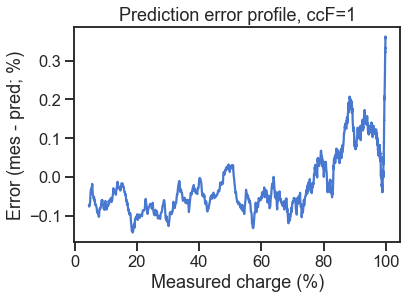

In [24]:
# Use previous prediction errors to find
# the standard deviation used to add noise:
ch_rol = moving_average(chs, n=200)
err_rol = moving_std(prs, n=200)
# Simulate profiles of different ccF:
simulate_err_profile(hl_df, 0.8, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 0.9, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 0.95, ch_rol, err_rol, noise_scale=1, roll_avg=200)
simulate_err_profile(hl_df, 1, ch_rol, err_rol, noise_scale=1, roll_avg=200)

The simulation shows that at a fraction of 20% incomplete cleavage/dephosphorylation (ccF=0.8) the characteristic shape is very clear.
It remains clear down to ~10% incomplete cleavage/dephosphorylation.
Therefore, given that the real data does not have this pattern there is no evidence of incomplete cleavage/dephosphorylation, and using other evidence from RNA gels, we can conclude that failure mode two is highly unlikely to have a substantial impact on the data.


### Analyzing the prediction errors

Naturally, the charge measurements have some degree of deviation from the decay function predicted charge.
This could be explained as random noise in the measurements but to substantiate such claim it is necessary to look for correlations between the prediction error and possible explanatory variables.
Of such variable the four most relevant are: sampling timepoint, replicate tube sampled from, barcoded adapter used and which sequencing batch used.

The results of the analysis is plotted below. In summary, it shows no concerning trends.
Optimally, each error distribution should be narrow and centered around zero which is the case for the timepoint, replicate and batch variables.
For the barcodes, the variability is slightly higher and some are offset from zero.
E.g. l4Sp which is on average yielding slightly higher measured charged compared to the prediction.
This trend for l4Sp is also confirmed in previous samples (using charge titration) but the magnitude of this offset is so small compared to the variance that it we will ignore it.

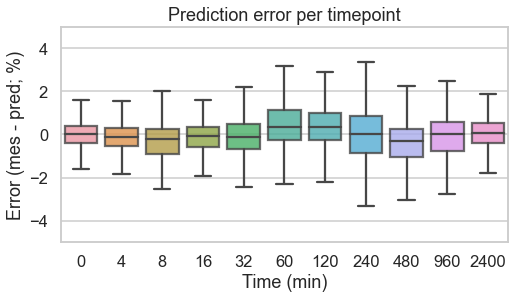

In [25]:
# Prediction error per timepoint:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='Time', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)

g1.set(xlabel='Time (min)', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Prediction error per timepoint')
fig.tight_layout()
fig.savefig('data/plotting_pub/timepoint_prediction-error.pdf', bbox_inches='tight')

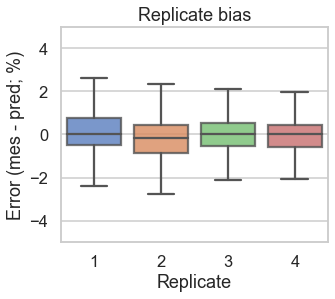

In [26]:
# Replicate bias:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='replicate', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)
g1.set(xlabel='Replicate', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Replicate bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/replicate_prediction-error.pdf', bbox_inches='tight')

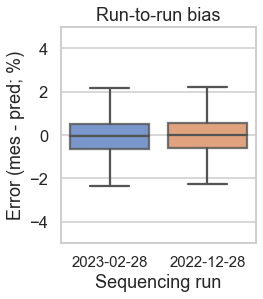

In [27]:
# Run-to-run bias:
ox_mask = (filt_df['Ox'])
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(4, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='run_v1', y='pred_err', \
                     boxprops=dict(alpha=0.8), fliersize=False)
g1.set_xticklabels(['2023-02-28', '2022-12-28'], rotation=0, size=15)
g1.set(xlabel='Sequencing run', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Run-to-run bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/run-to-run_prediction-error.pdf', bbox_inches='tight')

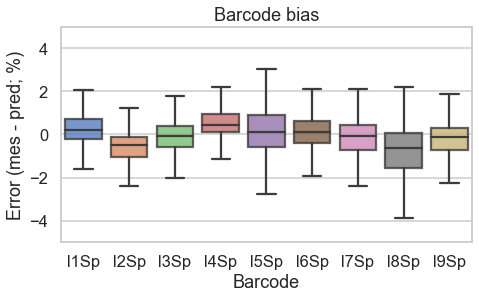

In [28]:
# Barcode bias:
ox_mask = (filt_df['Ox'])
bc_order = sorted(set(filt_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 4.5))
    g1 = sns.boxplot(ax=ax1, data=filt_df[ox_mask], x='barcode', y='pred_err', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)
# g1.set_xticklabels(g1.get_xticklabels(), rotation=30)
g1.set(xlabel='Barcode', ylabel='Error (mes - pred; %)', ylim=(-5, 5))
g1.set_title('Barcode bias')
fig.tight_layout()
fig.savefig('data/plotting_pub/barcode_prediction-error.pdf', bbox_inches='tight')

### Fitting a linear model to find predictors of half-life magnitude

Now that we have good half-life measurements, it would be interesting to find out what determines the large difference in aminoacylation stability.
Previous studies (e.g. Peacock et al. 2014) have concluded that half-life is determined by the amino acid identity but those conclusions were made on a small set of observations on a few _in vitro_ transcribed tRNAs.

Since we have a larger dataset of >150 transcripts, we can do a more formal analysis using linear regression.
We will limit this to readily accessible variables: amino acid, tRNA length, mito/cyto and the two most promixal variable nucleobases (the first and the descriminator base).
The analysis will be pretty simple and non-exhaustive: running the regression using all features and then selecting the features with t-statistics less than 0.05.
Although simple, we probably do not need to over complicate the analysis more given the outcome of the regression.

In [29]:
# Add first and discriminator base
# to the dataframe:
tRNA_data = dict()
tRNAdb_fnam = '{}/tRNA_database/human/hg38-tRNAs.fa'.format(homedir)
for record in SeqIO.parse(tRNAdb_fnam, "fasta"):
    tRNA_data[record.id] = dict()
    tRNA_data[record.id]['first_base'] = record.seq[0]
    tRNA_data[record.id]['second_base'] = record.seq[1]
    tRNA_data[record.id]['discr_base'] = record.seq[-4]

base_df = pd.DataFrame.from_dict(tRNA_data).transpose().reset_index().rename(columns={'index': 'tRNA_annotation'})
one_species_tab = one_species_tab.merge(base_df, on='tRNA_annotation', copy=False)
one_species_tab.to_csv('acylation_half-lifes_features.csv', index=False)

In [30]:
# Run OLS:
results = smf.ols('hl ~ amino_acid + tRNA_annotation_len + mito_codon + first_base + discr_base', data=one_species_tab).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     hl   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     617.9
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          1.76e-137
Time:                        16:16:46   Log-Likelihood:                -980.33
No. Observations:                 175   AIC:                             2019.
Df Residuals:                     146   BIC:                             2110.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             314.3808    

In [31]:
# Select feature with t-statistics less than 0.05,
# then rerun the model:
endog = pd.DataFrame(results.model.endog, columns=[results.model.endog_names])
exog = pd.DataFrame(results.model.exog, columns=results.model.exog_names)
cols_sele = ['Intercept',
             'amino_acid[T.Arg]',
             'amino_acid[T.Asn]',
             'amino_acid[T.Asp]',
             'amino_acid[T.Glu]',
             'amino_acid[T.Gly]',
             'amino_acid[T.Ile]',
             'amino_acid[T.Leu]',
             'amino_acid[T.Pro]',
             'amino_acid[T.Ser]',
             'amino_acid[T.Thr]',
             'amino_acid[T.Trp]',
             'amino_acid[T.Tyr]',
             'amino_acid[T.Val]',
             'discr_base[T.T]']
results = sm.OLS(endog, exog=exog.loc[:, cols_sele]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     hl   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1246.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):          2.08e-155
Time:                        16:16:46   Log-Likelihood:                -987.53
No. Observations:                 175   AIC:                             2005.
Df Residuals:                     160   BIC:                             2053.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           427.6016     11.31

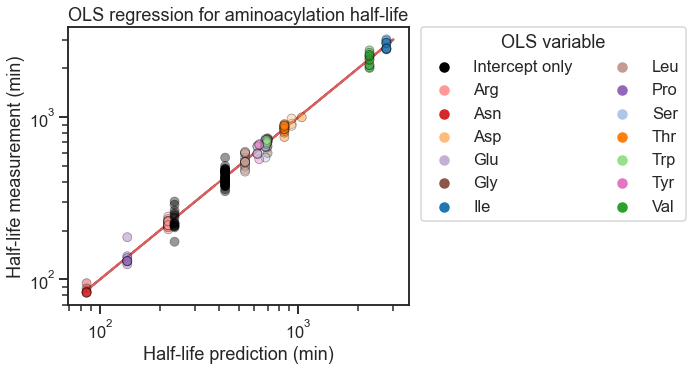

In [32]:
# Plot the regression results:
one_species_tab['hl_pred'] = results.fittedvalues.values
aa_sele = {'Arg', 'Asn', 'Asp', 'Glu', 'Gly', 'Ile', 'Leu', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val'}
AArgb_dict = dict()
cmap_b = mpl.colormaps['tab20']
for aai, aa in enumerate(aa_sele):
    AArgb_dict[aa] = cmap_b(aai)

color_list = list()
aa_sele_list = list()
for aa in one_species_tab['amino_acid']:
    if aa in aa_sele:
        color_list.append(AArgb_dict[aa])
        aa_sele_list.append(aa)
    else:
        color_list.append((0,0,0,1))
        aa_sele_list.append('Intercept only')

one_species_tab['Variable'] = aa_sele_list
sns_palette = {aa:col for aa, col in zip(aa_sele_list, color_list)}

fig, ax1 = plt.subplots(1, 1, figsize=(10, 5.5))
g1 = sns.scatterplot(ax=ax1, data=one_species_tab, x='hl_pred', y='hl', \
                     alpha=0.4, hue='Variable', \
                     edgecolor='black', linewidth=0.7, \
                     palette=sns_palette, \
                     zorder=10)

g1.set_xscale('log', base=10)
g1.set_yscale('log', base=10)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=2, title='OLS variable')
ax1.plot(one_species_tab['hl'], one_species_tab['hl'], \
         color='r', zorder=1)
g1.set(xlabel='Half-life prediction (min)', ylabel='Half-life measurement (min)')
g1.set_title('OLS regression for aminoacylation half-life')
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_OLS-prediction.pdf', bbox_inches='tight')

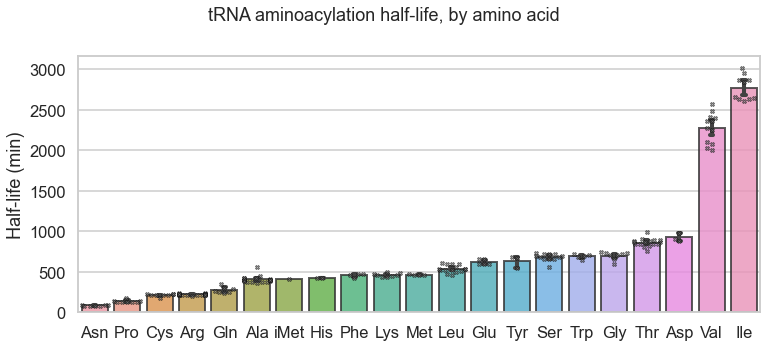

In [33]:
# Plot the amino acid influence on half-life
# in another (maybe simpler) way.

# Sort amino acids according to the mean half-life:
hl_mean_df = one_species_tab.groupby('amino_acid').agg(hl_mean=('hl', 'mean')).reset_index().sort_values(by='hl_mean').reset_index(drop=True)

# Plot half-life "waterfall" plot:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))

    g1 = sns.barplot(ax=ax1, data=one_species_tab, x='amino_acid', y='hl', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1, order=hl_mean_df['amino_acid'])
    g1 = sns.swarmplot(ax=ax1, data=one_species_tab, x='amino_acid', y='hl', dodge=True, \
                       color='grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=4, marker="X", zorder=2, order=hl_mean_df['amino_acid'], \
                       warn_thresh=1)
    g1.set(ylabel='Half-life (min)', xlabel='')


fig.suptitle('tRNA aminoacylation half-life, by amino acid', size=18)
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_waterfall.pdf', bbox_inches='tight')

In [59]:
# Data from tRNAseq:
hl_mean_std_df = one_species_tab.groupby('amino_acid').agg(mean=('hl', 'mean'), std=('hl', 'std')).reset_index().reset_index(drop=True)

# Data from Peacock et al.:
peacock_mean = {"Pro": 36, "Gln": 93, "Ala": 95, "Cys": 96, "Phe": 127, "Lys": 127, "His": 132, "Tyr": 141, "Leu": 147, "Ser": 202, "Val": 644, "Ile": 810}
peacock_std = {"Pro": 2, "Gln": 7, "Ala": 20, "Cys": 10, "Phe": 5, "Lys": 20, "His": 20, "Tyr": 30, "Leu": 4, "Ser": 10, "Val": 40, "Ile": 30}

df_mpea = pd.DataFrame.from_dict(peacock_mean, orient='index', columns=['mean'])
df_spea = pd.DataFrame.from_dict(peacock_std, orient='index', columns=['std'])
df_pea = df_mpea.merge(df_spea, left_index=True, right_index=True)
df_pea = df_pea.reset_index().rename(columns={'index': 'amino_acid'})

hl_method_comp = hl_mean_std_df.merge(df_pea, on='amino_acid', suffixes=('_tRNAseq', '_Peacock'))
hl_method_comp.head(3)

,amino_acid,mean_tRNAseq,std_tRNAseq,mean_Peacock,std_Peacock
0,Ala,405.970781,43.651446,95,20
1,Cys,210.954127,16.926327,96,10
2,Gln,278.483883,38.339081,93,7


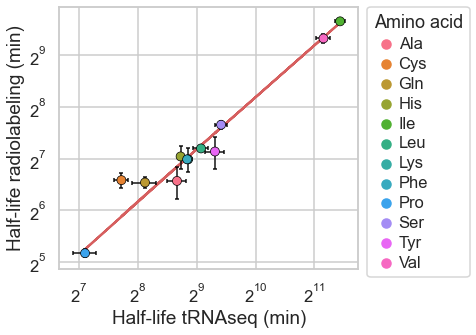

In [92]:
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
    g1 = sns.scatterplot(ax=ax1, data=hl_method_comp, x='mean_tRNAseq', y='mean_Peacock', \
                         hue='amino_acid',
                         zorder=5, alpha=1, \
                         edgecolor='black', linewidth=0.7)
    g1.set_xlabel('Half-life tRNAseq (min)', size=19)
    g1.set_ylabel('Half-life radiolabeling (min)', size=19)
    g1.set_yscale('log', base=2)
    g1.set_xscale('log', base=2)
    ax1.errorbar(hl_method_comp['mean_tRNAseq'].values, hl_method_comp['mean_Peacock'].values, \
                 xerr=hl_method_comp['std_tRNAseq'].values, yerr=hl_method_comp['std_Peacock'].values, \
                 fmt='none', capsize=2, zorder=2, \
                 ecolor='black', elinewidth=2, capthick=2, alpha=0.7)

    x = hl_method_comp['mean_tRNAseq'].values
    y = hl_method_comp['mean_Peacock'].values
    linreg = stats.linregress(x, y)
    ax1.plot(x, linreg.intercept + linreg.slope*x, 'r', zorder=1)

    sns.move_legend(g1, "upper left", bbox_to_anchor=(1.03, 1), frameon=True, ncol=1, \
                    alignment='left', labelspacing=0.3, handletextpad=0, borderaxespad=0, \
                    handlelength=1.5, title='Amino acid')

    fig.tight_layout()
    fig.savefig('data/plotting_pub/hl_comp_peacock.pdf', bbox_inches='tight')

The regression analysis shows what could be expected based on previous findings - that the aminoacylation half-life is mostly controlled by the amino acid identity.
Therefore, it is not suprising that all other features did not contribute significantly to the model, with the exception of a T on the discriminator base.

The discriminator base is typically an A, but not always.
Let us look at the discriminator base distribution for tRNAs carrying the same amino acid.

In [34]:
discrb_df = one_species_tab.groupby('amino_acid').agg({'discr_base': ','.join}).reset_index()
discrb_df['discr_base_set'] = [set(s.split(',')) for s in discrb_df['discr_base']]
aa_mask = [True if len(ds)>1 and 'T' in ds else False for ds in discrb_df['discr_base_set']]
discrb_df

,amino_acid,discr_base,discr_base_set
0,Ala,"A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A",{A}
1,Arg,"A,G,G,G,G,A,G,A,G,G,A,G,A,G,G,G,G,G","{G, A}"
2,Asn,"G,G,G,G,G,G,G",{G}
3,Asp,"A,G,G","{G, A}"
4,Cys,"T,T,T,T,T,T,T,T",{T}
5,Gln,"G,T,T,T,T,T,T","{G, T}"
6,Glu,"A,A,A,A,A",{A}
7,Gly,"A,A,A,A,A,A,A,A",{A}
8,His,"C,A","{C, A}"
9,Ile,"A,A,A,A,A,A,A,A,A,A",{A}


As it can be seen above, there are only three examples of amino acids being carried by tRNAs with T as the discriminator base: Cys, Gln and Thr.
Of these, only Gln and Thr are also being carried by tRNAs with discriminator bases different from T.
These are interesting because they are direct examples of the aminoacylation stability effect of the discriminator base.
Let us therefore isolate and illustrate the difference.

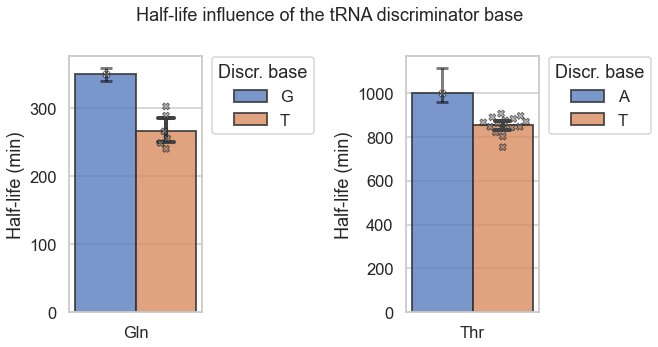

In [35]:
# Extract CI error bar data
# and align it to swarmplot jittered data:
def swarm_err(swarm, df):
    err = list()
    x = list()
    y = list()
    for c in swarm.collections:
        d = c.get_offsets()
        for dot in d:
            pmask = (df['hl'] == dot[1])
            if np.any(pmask):
                ci = df.loc[pmask, ['hl_ci_l', 'hl_ci_u']].values[0]
                ci = np.abs(ci - dot[1])
                err.append([[ci[0]], [ci[1]]])
                x.append(dot[0])
                y.append(dot[1])
    
    err = np.array(err)
    err = err.T[0]
    return(err, x, y)

# Selected either Gln or Thr amino acid:
mGln = (one_species_tab['amino_acid'] == 'Gln') 
mThr = (one_species_tab['amino_acid'] == 'Thr')
nonT = (one_species_tab['discr_base'] != 'T')

# Plot side by side:
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 5))

    g1 = sns.barplot(ax=ax1, data=one_species_tab[mGln], x='amino_acid', y='hl', \
                     hue='discr_base', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1)
    g1 = sns.swarmplot(ax=ax1, data=one_species_tab[mGln], x='amino_acid', y='hl', \
                       hue='discr_base', dodge=True, \
                       palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=7, marker="X", legend=False, \
                       zorder=2)
    sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Discr. base')
    g1.set(xlabel='', ylabel='Half-life (min)')
    
    err, x, y = swarm_err(g1, one_species_tab[mGln&nonT])
    ax1.errorbar(x, y, yerr=err, fmt='none', capsize=6, zorder=30, \
                 ecolor='black', elinewidth=3, capthick=3, alpha=0.5)

    g2 = sns.barplot(ax=ax2, data=one_species_tab[mThr], x='amino_acid', y='hl', \
                     hue='discr_base', \
                     capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8, \
                     zorder=1)
    g2 = sns.swarmplot(ax=ax2, data=one_species_tab[mThr], x='amino_acid', y='hl', \
                       hue='discr_base', dodge=True, \
                       palette='light:grey', alpha=0.6, edgecolor='black', linewidth=0.8, \
                       size=7, marker="X", legend=False, \
                       zorder=1)
    sns.move_legend(g2, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='Discr. base')
    g2.set(xlabel='', ylabel='Half-life (min)')

    err, x, y = swarm_err(g2, one_species_tab[mThr&nonT])
    ax2.errorbar(x, y, yerr=err, fmt='none', capsize=6, zorder=30, \
                 ecolor='black', elinewidth=3, capthick=3, alpha=0.5)

fig.suptitle('Half-life influence of the tRNA discriminator base', size=18)
fig.tight_layout()
fig.savefig('data/plotting_pub/half-life_disc-base.pdf', bbox_inches='tight')

It looks like having T as discriminator base slightly reduces the half-life; however, the effect size is small and the conclusion rests on observations from just two transcripts.


## Overall conclusions
* RNA integrity is good: no substantial degradation seen on RNA gel and confirmed by stable RPM and non-oxidized controls.
* Ecoli spike-in control shows almost complete oxidation and base cleavage, thus showing that the data is quantitative down to low single digit charge percentages.
* Non-oxidized controls shows ~100% charge, thus showing that the data is quantitative up to 100% charge.
* Data precision is independent of sampling time, replicate batch and sequencing batch.
* Adapter barcodes have negligible influence on data precision.
* Aminoacylation half-life can be determined with good precision.
* The data have enough sensitivity to detect tRNA transcripts that are likely to carry two different aminoacyl attachments with different half-lifes.
* Aminoacylation half-life is determined primarily by the aminoacyl attachment but is also likely influenced to a smaller degree by the discriminator base.